# How to build a reliable, curated, and accurate RAG system using Cleanlab and Pinecone

In [125]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import time
from IPython.display import display
import warnings
import matplotlib.pyplot as plt
import os
import pinecone
import uuid
from pinecone import ServerlessSpec
from typing import List, Tuple, Dict, Optional

warnings.simplefilter(action='ignore', category=FutureWarning)

In [126]:
os.environ["PINECONE_API_KEY"] = "YOUR PINECONE API KEY HERE"

Below is an example of how to set a Python index serverless specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [127]:
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [128]:
class PineconeRAGPipeline:
    def __init__(self, model_name: str = 'paraphrase-MiniLM-L6-v2', index_name: str = 'document-index', cloud: str = 'aws', region: str = 'us-east-1'):
        """
        Initialize the PineconeRAGPipeline with a specified model and index name.
        
        Args:
            model_name (str): Name of the SentenceTransformer model to use.
            index_name (str): Name of the Pinecone index to create or connect to.
            cloud (str): Cloud provider for Pinecone.
            region (str): Region for the Pinecone service.
        """
        self.model = SentenceTransformer(model_name)
        self.pc = pinecone.Pinecone(api_key=os.environ.get('PINECONE_API_KEY'))
        self.index_name = index_name
        
        existing_indexes = self.pc.list_indexes()
        
        if self.index_name not in existing_indexes:
            try:
                print(f"Creating new index: {self.index_name}")
                self.pc.create_index(
                    name=self.index_name,
                    dimension=self.model.get_sentence_embedding_dimension(),
                    metric='cosine',
                    spec=pinecone.ServerlessSpec(cloud=cloud, region=region)
                )
            except Exception as e:
                if "ALREADY_EXISTS" in str(e):
                    print(f"Index {self.index_name} already exists. Connecting to existing index.")
                else:
                    raise e
        else:
            print(f"Index {self.index_name} already exists. Connecting to existing index.")
        
        self.index = self.pc.Index(self.index_name)

    def chunk_text(self, text: str, max_tokens: int = 256) -> List[str]:
        """
        Split text into chunks based on a maximum token size.
        
        Args:
            text (str): The document text to be chunked.
            max_tokens (int): The maximum number of tokens per chunk.
        
        Returns:
            List[str]: List of text chunks.
        """
        words = text.split()
        chunks = []
        current_chunk = []
        current_chunk_tokens = 0

        for word in words:
            word_tokens = len(self.model.tokenize([word])['input_ids'][0])
            if current_chunk_tokens + word_tokens > max_tokens and current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_chunk_tokens = 0
            
            current_chunk.append(word)
            current_chunk_tokens += word_tokens

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        for i, chunk in enumerate(chunks):
            print(f"Chunk {i+1} length: {len(chunk)} characters, {len(self.model.tokenize([chunk])['input_ids'][0])} tokens")

        return chunks
    
    def index_documents(self, df: pd.DataFrame) -> int:
        """
        Index documents from a DataFrame with specific metadata structure.
        
        Args:
            df (pd.DataFrame): DataFrame containing document information and metadata.
                               Expected columns: 'text', 'filename', 'topic', 'quality'
        
        Returns:
            int: The number of chunks successfully indexed.
        """
        valid_docs = []
        valid_metadata = []
        generated_ids = []

        print("Starting document processing...")

        for idx, row in df.iterrows():
            if pd.isna(row['text']) or pd.isna(row['filename']) or pd.isna(row['topic']):
                print(f"Skipping invalid document at index {idx}: {row['filename']}")
                continue
            
            doc = str(row['text'])
            print(f"Processing document {row['filename']} at index {idx}...")

            chunks = self.chunk_text(doc)

            for i, chunk in enumerate(chunks):
                chunk_id = str(uuid.uuid4())
                chunk_metadata = {
                    'filename': row['filename'],
                    'topic': row['topic'],
                    'chunk_index': i,
                    'total_chunks': len(chunks),
                    'quality': row['quality'] if not pd.isna(row['quality']) else 'unknown',
                    'chunk_id': chunk_id
                }
                valid_docs.append(chunk)
                valid_metadata.append(chunk_metadata)
                generated_ids.append(chunk_id)

        print(f"Total chunks to encode: {len(valid_docs)}")

        if not valid_docs:
            print("No valid documents to index.")
            return 0

        doc_embeddings = self.model.encode(valid_docs)

        batch_size = 100
        for i in range(0, len(valid_docs), batch_size):
            batch_docs = valid_docs[i:i+batch_size]
            batch_metadata = valid_metadata[i:i+batch_size]
            batch_embeddings = doc_embeddings[i:i+batch_size]
            
            vectors = [
                (generated_ids[i+j], embedding.tolist(), {**metadata, 'text': doc[:1000]})
                for j, (doc, embedding, metadata) in enumerate(zip(batch_docs, batch_embeddings, batch_metadata))
            ]

            try:
                self.index.upsert(vectors=vectors)
                print(f"Successfully indexed batch of {len(vectors)} chunks.")
            except Exception as e:
                print(f"Error during upsert: {e}")

        print("Document indexing completed.")
        return len(valid_docs)

    def search(self, query: str, top_k: int = 5, filter_query: Optional[Dict] = None) -> List[Tuple[str, Dict]]:
        """
        Search for the top_k most relevant documents based on the input query and optional filter.
        
        Args:
            query (str): The search query text.
            top_k (int): The number of top relevant documents to return.
            filter_query (Optional[Dict]): Optional filter query to apply during search.
        
        Returns:
            List[Tuple[str, Dict]]: List of top_k relevant document texts and their metadata.
                                    Each tuple contains (document_text, metadata_dict).
        """
        query_embedding = self.model.encode(query)
        
        try:
            results = self.index.query(
                vector=query_embedding.tolist(),
                top_k=top_k,
                filter=filter_query,
                include_metadata=True
            )
            
            return [(match.metadata['text'], {k: v for k, v in match.metadata.items() if k != 'text'}) for match in results.matches]
        except Exception as e:
            print(f"Error during search: {e}")
            return []

    def delete_index(self) -> None:
        """
        Delete the Pinecone index.
        
        Raises:
            Exception: If there's an error during the deletion process.
        """
        try:
            self.pc.delete_index(self.index_name)
            print(f"Index '{self.index_name}' has been deleted.")
        except Exception as e:
            print(f"Error deleting index: {e}")

    def extract_chunks_from_index(self) -> pd.DataFrame:
        """
        Extract document chunks and metadata from the Pinecone index into a DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame containing chunk data and metadata.
                          Columns include all metadata fields stored in the index.
        
        Raises:
            Exception: If there's an error retrieving chunks from the index.
        """
        stats = self.index.describe_index_stats()
        total_vectors = stats.total_vector_count
        dimension = stats.dimension
        
        print(f"Index name: {self.index_name}")
        print(f"Total vectors according to stats: {total_vectors}")
        print(f"Vector dimension: {dimension}")

        try:
            results = self.index.query(
                vector=[0.0] * dimension,
                top_k=10000,
                include_values=False,
                include_metadata=True
            )

            chunk_data = [match.metadata for match in results.matches]
            chunk_df = pd.DataFrame(chunk_data)

            print(f"Total chunks retrieved: {len(chunk_df)}")
            return chunk_df

        except Exception as e:
            print(f"Error retrieving chunks from index: {e}")
            return pd.DataFrame()

    def delete_chunks(self, chunk_ids: List[str]) -> None:
        """
        Delete specific chunks from the Pinecone index.

        Args:
            chunk_ids (List[str]): List of chunk IDs to delete.
        
        Raises:
            Exception: If there's an error during the deletion process.
        """
        try:
            self.index.delete(ids=chunk_ids)
            print(f"Successfully deleted {len(chunk_ids)} chunks from the index.")
        except Exception as e:
            print(f"Error deleting chunks: {e}")
            print(f"Problematic chunk IDs: {chunk_ids}")

        print(f"Finished deletion process for {len(chunk_ids)} chunks.")

## Load Documents Data

In [129]:
# Read in dataset
df = pd.read_csv("document-curation-RAG.csv")
print(df.shape)

(139, 5)


In [130]:
df.head()

,index,filename,topic,quality,text
0,1,documents/Blackstone-Third-Quarter-2023-Invest...,finance,good,Blackstone Third Quarter 2023 Investor Call Oc...
1,2,documents/8k-nike.pdf,finance,good,SECURITIES AND EXCHANGE COMMISSIONFORM 8-K Cur...
2,3,documents/04-FY24-Q1-NIKE-Press-Release.pdf,finance,good,Investor Contact:Media Contact:Paul TrussellVi...
3,4,documents/10-K 2022-Apple2.pdf,finance,good,The future principal payments for the Company’...
4,5,documents/q3-fy22-earnings-presentation.pdf,finance,NaN,Financial\tpresentation\tto\t accompany\tmanag...


## Analyze Documents Data

Summary Statistics of Text Length:
count       139.00000
mean       9474.00000
std       18093.41533
min           0.00000
25%        1776.50000
50%        3727.00000
75%        8104.00000
max      143918.00000
Name: text_length, dtype: float64


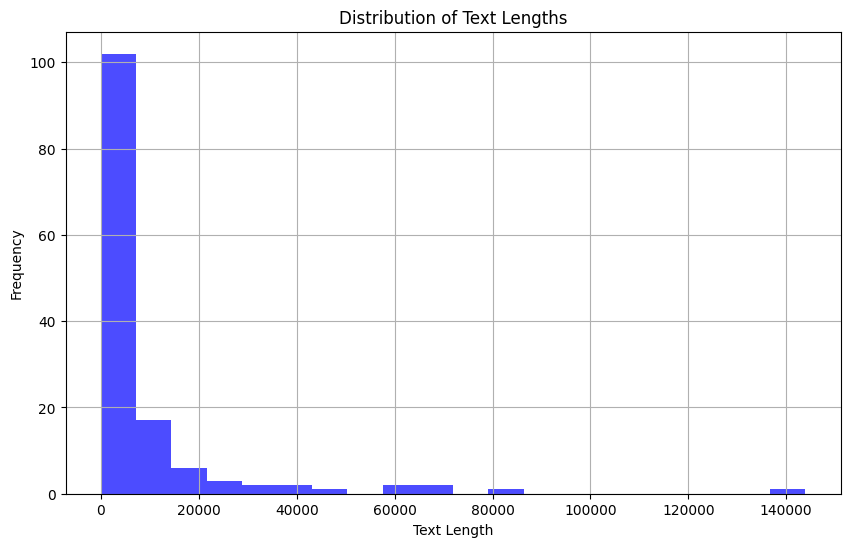

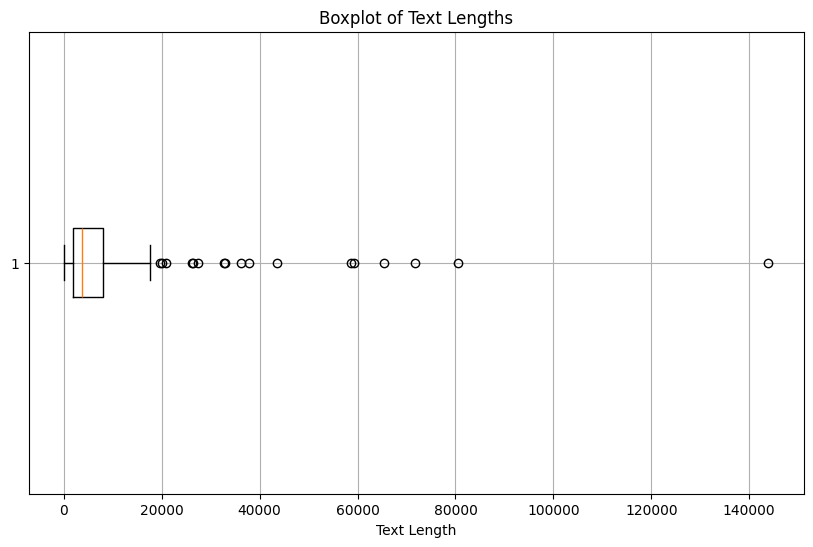

In [131]:
# Calculate the length of the text in the 'text' column
df['text_length'] = df['text'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Summary statistics
length_stats = df['text_length'].describe()
print("Summary Statistics of Text Length:")
print(length_stats)

# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Optional: plot a boxplot to see the distribution with outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df['text_length'], vert=False)
plt.title('Boxplot of Text Lengths')
plt.xlabel('Text Length')
plt.grid(True)
plt.show()

In [132]:
# Analyze missing values
missing_values = df.isnull().sum()
print(f"\nMissing Values in Each Column:\n{missing_values}")

# Analyze the 'quality' column
quality_counts = df['quality'].value_counts(dropna=False)
print(f"\nQuality Column Distribution:\n{quality_counts}")

# Quality distribution per topic
quality_topic_distribution = df.pivot_table(index='topic', columns='quality', aggfunc='size', fill_value=0)
print(f"\nQuality Distribution per Topic:\n{quality_topic_distribution}")


Missing Values in Each Column:
index            0
filename         0
topic            0
quality        103
text             3
text_length      0
dtype: int64

Quality Column Distribution:
quality
NaN     103
good     18
bad      18
Name: count, dtype: int64

Quality Distribution per Topic:
quality  bad  good
topic             
finance    2     6
hr         2     5
it         9     1
product    2     3
sales      3     3


## Initialize RAG Pipeline on initial documents data

In [1]:
# Intialize RAG pipeline on unfiltered documents
rag_pipeline = PineconeRAGPipeline(index_name='cleanlab-pinecone-index')
rag_pipeline.index_documents(df)

In [134]:
time.sleep(30)
# Extract chunks from the Pinecone index into a DataFrame
chunk_df = rag_pipeline.extract_chunks_from_index()

# Display the resulting DataFrame
chunk_df.head()

Index name: cleanlab-pinecone-index
Total vectors according to stats: 2716
Vector dimension: 384
Total chunks retrieved: 2716


,chunk_id,chunk_index,filename,quality,text,topic,total_chunks
0,1d38c13a-0dac-4cdd-9c3e-412ca97c871e,4.0,documents/Walmart_2022_Investor_Information.pdf,unknown,follows:2023HighLow1st Quarter(1)$146.94$132.0...,finance,9.0
1,22f6030f-68ad-424b-9428-dea4dd8d2e1a,5.0,documents/internet_safety.pptx,bad,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...",it,6.0
2,afe7e494-26df-4a0e-91f3-16b7d0d66849,139.0,documents/Investor_Transcript_2023-10-26.pdf,unknown,"PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY B...",finance,141.0
3,4f2ad85b-2a39-4e63-b197-7f5beb6eeeb4,5.0,documents/2012_14.doc,unknown,Pay transactions on HUE01 using the following ...,finance,17.0
4,b46158c1-6514-4b97-a49e-28024ce58fb2,3.0,documents/01-danby-3cuft-range.pdf,unknown,DetailsWeight63.00kg138.89lbCapacityLoading Ca...,product,5.0


In [135]:
chunk_df.shape

(2716, 7)

In [138]:
document_data_columns = list(chunk_df.columns)
print(f"The columns in our documents data are: {document_data_columns}")

The columns in our documents data are: ['chunk_id', 'chunk_index', 'filename', 'quality', 'text', 'topic', 'total_chunks']


We can see below that the number of chunks per document varies:

In [139]:
chunks_per_doc = chunk_df.groupby('filename')['chunk_index'].max() + 1
print(chunks_per_doc)

filename
documents/0-cognism-how-to-sell.pdf                 29.0
documents/01-danby-3cuft-range.pdf                   5.0
documents/02-Internet_and_Technology_Policy.docx     5.0
documents/03-job-offer-worksheet-aug-2019.docx       7.0
documents/04-FY24-Q1-NIKE-Press-Release.pdf         26.0
                                                    ... 
documents/unit04.pdf                                22.0
documents/v0_FarmFreshFeast_financials.docx          7.0
documents/v0_FarmFreshFeast_financials.pdf           7.0
documents/what-is-selling.pptx                       7.0
documents/work-ez-specs.pdf                          2.0
Name: chunk_index, Length: 136, dtype: float64


## Use Cleanlab Studio to ensure there is no low quality or unacceptable text in our documents (e.g. PII, duplicates, non-English text, toxic language, etc.)

Cleanlab Studio runs many analyses of your dataset to find data issues and provide other useful metadata, including detection of: label issues, outliers, ambiguous examples, well-labeled examples, and more. For this particular use case, we will focus on text-specific data issues that Cleanlab can detect. After Cleanlab Studio runs these analyses on your data, new metadata columns are available to show the issue types detected and the severity of the issue type.

We will first ingest the document chunks data obtained from our Pinecone DB into Cleanlab Studio and then run a project to analyze this data and look for the text issue types mentioned. After the project results are ready, we can make use of the `download_cleanlab_columns()` column to download the added metadata columns from the Cleanlab Studio project results.

For more details on Cleanlab Studio Metadata you can go [here](https://help.cleanlab.ai/guide/concepts/cleanlab_columns/).

In [143]:
from cleanlab_studio import Studio

API_KEY = "YOUR API KEY HERE"
studio = Studio(API_KEY)

### Ingest our documents chunks into Cleanlab Studio

In [144]:
dataset_id = studio.upload_dataset(
    chunk_df,
    dataset_name="cleanlab_pinecone_RAG_document_chunks"
)
print(f"Dataset ID: {dataset_id}")

Uploading dataset...: 100%|██████████|
Ingesting Dataset...: 100%|██████████|

Dataset ID: 1169f187757e43079b5cc9b7d93b482e


### Launch a Cleanlab Studio Project using our documents data to analyze the text

In [145]:
text_column = "text"

We will use Cleanlab Studio’s Python API to analyze and find issues in this documents dataset that does not have labels. This can be useful if you don’t have a single column in your dataset that you want to predict values for but still want to find issues such as low-quality text content (e.g. toxic or unreadable text). In machine learning nomenclature, working with such data is called unsupervised learning (because there is no supervised label to predict).

In [146]:
project_id = studio.create_project(
    dataset_id=dataset_id,
    project_name="Cleanlab Pinecone RAG Document Chunks Project",
    modality="text",
    task_type="unsupervised",
    model_type="regular",  
    label_column=None,
    text_column=text_column
)
print(f"Project successfully created and training has begun! project_id: {project_id}")

Project successfully created and training has begun! project_id: e769dc99ec174f0ba8abedc786587e22


In [147]:
cleanset_id = studio.get_latest_cleanset_id(project_id)
project_status = studio.wait_until_cleanset_ready(cleanset_id)

Cleanset Progress: / Step 25/25, Ready for review!


In [148]:
# Download cleanlab columns from text project
cleanlab_columns = studio.download_cleanlab_columns(cleanset_id)

In [149]:
print(cleanlab_columns.columns)

Index(['cleanlab_row_ID', 'is_near_duplicate', 'near_duplicate_score',
       'near_duplicate_cluster_id', 'is_outlier', 'outlier_score',
       'is_empty_text', 'text_num_characters', 'is_PII', 'PII_score',
       'PII_types', 'PII_items', 'is_informal', 'informal_score',
       'spelling_issue_score', 'grammar_issue_score', 'slang_issue_score',
       'is_non_english', 'non_english_score', 'predicted_language', 'is_toxic',
       'toxic_score', 'sentiment_score', 'bias_score', 'is_biased',
       'gender_bias_score', 'racial_bias_score',
       'sexual_orientation_bias_score'],
      dtype='object')


## Check for issues detected by Cleanlab Studio in our documents data

In [150]:
# Combine DataFrame with Cleanlab columns
cleanlab_df = chunk_df.merge(
    cleanlab_columns, left_index=True, right_index=True
)

display(cleanlab_df.head())

,chunk_id,chunk_index,filename,quality,text,topic,total_chunks,cleanlab_row_ID,is_near_duplicate,near_duplicate_score,...,non_english_score,predicted_language,is_toxic,toxic_score,sentiment_score,bias_score,is_biased,gender_bias_score,racial_bias_score,sexual_orientation_bias_score
0,1d38c13a-0dac-4cdd-9c3e-412ca97c871e,4.0,documents/Walmart_2022_Investor_Information.pdf,unknown,follows:2023HighLow1st Quarter(1)$146.94$132.0...,finance,9.0,1,False,0.355809,...,0.121850,<NA>,False,0.059357,0.631897,0.157471,False,0.0,0.157471,1.859660e-05
1,22f6030f-68ad-424b-9428-dea4dd8d2e1a,5.0,documents/internet_safety.pptx,bad,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...",it,6.0,2,False,0.191369,...,0.392422,<NA>,False,0.082031,0.571747,0.102356,False,0.0,0.102356,1.066208e-03
2,afe7e494-26df-4a0e-91f3-16b7d0d66849,139.0,documents/Investor_Transcript_2023-10-26.pdf,unknown,"PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY B...",finance,141.0,3,False,0.255100,...,0.041649,<NA>,False,0.121399,0.402893,0.090332,False,0.0,0.090332,7.153000e-07
3,4f2ad85b-2a39-4e63-b197-7f5beb6eeeb4,5.0,documents/2012_14.doc,unknown,Pay transactions on HUE01 using the following ...,finance,17.0,4,False,0.400400,...,0.037601,<NA>,False,0.063538,0.620850,0.156860,False,0.0,0.156860,1.192000e-07
4,b46158c1-6514-4b97-a49e-28024ce58fb2,3.0,documents/01-danby-3cuft-range.pdf,unknown,DetailsWeight63.00kg138.89lbCapacityLoading Ca...,product,5.0,5,False,0.307199,...,0.121605,<NA>,False,0.108521,0.708740,0.205078,False,0.0,0.205078,1.251700e-06


In [151]:
cleanlab_df.shape

(2716, 35)

In [152]:
outlier_issues = cleanlab_df.query("is_outlier").sort_values("outlier_score", ascending=False)

outlier_columns = ["outlier_score", "is_outlier"]
columns_to_display = [text_column] + outlier_columns

print(f"There are {len(outlier_issues)} outliers in our documents data.")
display(outlier_issues.head(5)[columns_to_display])

There are 0 outliers in our documents data.


,text,outlier_score,is_outlier


In [153]:
near_duplicates = cleanlab_df.query("is_near_duplicate").sort_values(by=["near_duplicate_cluster_id", "near_duplicate_score"])

near_duplicate_columns = ["near_duplicate_score", "near_duplicate_cluster_id", "is_near_duplicate"]
columns_to_display = [text_column] + near_duplicate_columns

print(f"There are {len(near_duplicates)} near (or exact) duplicates in our documents data. Here are some examples below:\n")
display(near_duplicates.head()[columns_to_display])

There are 150 near (or exact) duplicates in our documents data. Here are some examples below:



,text,near_duplicate_score,near_duplicate_cluster_id,is_near_duplicate
14,ElectraSpeedTech - Product SpecificationProduc...,0.883742,0,True
276,[OUTDATED] ElectraSpeedTech - Product Specific...,0.887206,0,True
1083,[OUTDATED] ElectraSpeedTech - Product Specific...,0.887206,0,True
34,to: - Define insider training and understand i...,1.000000,1,True
132,to: - Define insider training and understand i...,1.000000,1,True


In [154]:
pii_issues = cleanlab_df.query("is_PII").sort_values("PII_score", ascending=False)

pii_columns = ["PII_items", "PII_types", "PII_score", "is_PII"]
columns_to_display = [text_column] + pii_columns

print(f"There are {len(pii_issues)} PII issues in our documents data. Here are some examples below:\n")
display(pii_issues.head(5)[columns_to_display])

There are 176 PII issues in our documents data. Here are some examples below:



,text,PII_items,PII_types,PII_score,is_PII
1,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...","[""(800) 487-1626"", ""dls.stat@dss.mo.gov""]","[""email"", ""phone number""]",0.5,True
569,and Confirming prospectus requirements. Contac...,"[""(631) 254-7112""]","[""phone number""]",0.5,True
778,(1)$%(19)(1)%1216%241%272%624%(30)(3)%142%41%(...,"[""2022 5 2021 4""]","[""phone number""]",0.5,True
2010,"(603) 230-5001. After completing Form DP-80, e...","[""(603) 230-5001""]","[""phone number""]",0.5,True
2039,JohnsonRole: Senior Sales RepPhone: (408) 555-...,"[""alexjohn@bestbuy.comMailing"", ""mgarcia@bestb...","[""email""]",0.5,True


In [155]:
display(pii_issues[columns_to_display])

,text,PII_items,PII_types,PII_score,is_PII
1,"751-5980 (800) 487-1626 (8 a.m. to 5 p.m. CST,...","[""(800) 487-1626"", ""dls.stat@dss.mo.gov""]","[""email"", ""phone number""]",0.5,True
569,and Confirming prospectus requirements. Contac...,"[""(631) 254-7112""]","[""phone number""]",0.5,True
778,(1)$%(19)(1)%1216%241%272%624%(30)(3)%142%41%(...,"[""2022 5 2021 4""]","[""phone number""]",0.5,True
2010,"(603) 230-5001. After completing Form DP-80, e...","[""(603) 230-5001""]","[""phone number""]",0.5,True
2039,JohnsonRole: Senior Sales RepPhone: (408) 555-...,"[""alexjohn@bestbuy.comMailing"", ""mgarcia@bestb...","[""email""]",0.5,True
...,...,...,...,...,...
662,that are notpart of a geographic operating seg...,"[""www.secdatabase.com.""]","[""URL""]",0.1,True
660,reports on Form 10-Q which are available on Na...,"[""http://ir.nasdaq.com"", ""www.sec.gov.""]","[""URL""]",0.1,True
599,share:Basic$0.94$1.18Diluted$0.93$1.16Weighted...,"[""www.secdatabase.com.""]","[""URL""]",0.1,True
598,uncertainties that could cause actual results ...,"[""www.secdatabase.com.""]","[""URL""]",0.1,True


In [156]:
informal_issues = cleanlab_df.query("is_informal").sort_values("informal_score", ascending=False)

informal_columns = ["informal_score", "is_informal", 'spelling_issue_score', 'grammar_issue_score', 'slang_issue_score']
columns_to_display = [text_column] + informal_columns

print(f"There are {len(informal_issues)} informal issues in our documents data. Here are some examples below:\n")
display(informal_issues.head(5)[columns_to_display])

There are 187 informal issues in our documents data. Here are some examples below:



,text,informal_score,is_informal,spelling_issue_score,grammar_issue_score,slang_issue_score
2055,’04). IAC Travel revenue as if Hotels.com on n...,0.721339,True,0.468085,0.842566,0.726739
127,Ð²Ñ‹Ñ​Ñ‚Ð°Ð²ÐºÐ°Ñ… Ð¸ ÐºÐ¾Ð½Ñ„ÐµÑ€ÐµÐ½Ñ†Ð¸Ñ​Ñ…...,0.718154,True,1.000000,0.395306,0.900079
887,LightAluminumLength = 14” Width = 10”Length = ...,0.712504,True,0.647059,0.761268,0.696463
2063,Ð¿Ñ€ÐµÐ´Ð»Ð°Ð³Ð°ÐµÐ¼.2. Ð£Ñ‡Ð°Ñ​Ñ‚Ð¸Ðµ Ð² Ð²Ñ‹...,0.711850,True,0.941176,0.416568,0.892469
1028,Ñ„ÐµÑ€Ð¼Ð°Ñ….2. Ð¡ÐµÐ»ÑŒÑ​ÐºÐ¾Ñ…Ð¾Ð·Ñ​Ð¹Ñ​Ñ‚Ð²...,0.700107,True,0.850000,0.443556,0.881711


In [157]:
biased_issues = cleanlab_df.query("is_biased").sort_values("bias_score", ascending=False)

biased_columns = ["bias_score", "is_biased", 'gender_bias_score', 'racial_bias_score', 'sexual_orientation_bias_score']
columns_to_display = [text_column] + biased_columns

print(f"There are {len(biased_issues)} biased issues in our documents data.")
display(biased_issues.head(5)[columns_to_display])

There are 1 biased issues in our documents data.


,text,bias_score,is_biased,gender_bias_score,racial_bias_score,sexual_orientation_bias_score
47,Company takes the problem of drug and alcohol ...,0.826465,True,0.826465,0.200439,0.604492


In [158]:
toxic_issues = cleanlab_df.query("is_toxic").sort_values("toxic_score", ascending=False)

toxic_columns = ['is_toxic', 'toxic_score']
columns_to_display = [text_column] + toxic_columns

print(f"There are {len(toxic_issues)} toxic issues in our documents data. Here are some examples below:\n")
display(toxic_issues.head(5)[columns_to_display])

There are 5 toxic issues in our documents data. Here are some examples below:



,text,is_toxic,toxic_score
1022,YOU ARE A HORRIBLE CFO why in the world would ...,True,0.858887
1308,fun of or making derogatory remarks about some...,True,0.840820
1996,"To the HR Department,GO DIE!It's become increa...",True,0.834473
638,"not use social networking accounts to harass, ...",True,0.816895
57,I hope this email finds you well – though with...,True,0.812500


In [159]:
non_english_issues = cleanlab_df.query("is_non_english").sort_values("non_english_score", ascending=False)

non_english_columns = ['is_non_english', 'non_english_score', 'predicted_language']
columns_to_display = [text_column] + non_english_columns

print(f"There are {len(non_english_issues)} non English issues in our documents data. Here are some examples below:\n")
display(non_english_issues.head(5)[columns_to_display])

There are 55 non English issues in our documents data. Here are some examples below:



,text,is_non_english,non_english_score,predicted_language
127,Ð²Ñ‹Ñ​Ñ‚Ð°Ð²ÐºÐ°Ñ… Ð¸ ÐºÐ¾Ð½Ñ„ÐµÑ€ÐµÐ½Ñ†Ð¸Ñ​Ñ…...,True,0.989548,<NA>
256,Ð¾Ð·Ñ​Ð¹Ñ​Ñ‚Ð²ÐµÐ½Ð½Ñ‹Ñ… Ñ€ÐµÑˆÐµÐ½Ð¸Ð¹ Ð´Ð»Ñ​...,True,0.989083,<NA>
255,ÐºÐ°Ð¼Ð¿Ð°Ð½Ð¸Ð¸ Ð¸ Ñ€ÐµÐºÐ»Ð°Ð¼Ð½Ñ‹Ðµ Ð°ÐºÑ†Ð...,True,0.988594,<NA>
2071,Ð²Ð°ÑˆÐ¸Ñ… Ñ†ÐµÐ»ÐµÐ¹ Ð² Ñ​ÐµÐ»ÑŒÑ​ÐºÐ¾Ð¼ Ñ…Ð¾...,True,0.987874,<NA>
515,Ñ€Ð°Ð·Ñ€Ð°Ð±Ð¾Ñ‚ÐºÐµ ÑƒÐ¼Ð½Ñ‹Ñ… Ñ​ÐµÐ»ÑŒÑ​ÐºÐ¾...,True,0.987554,<NA>


We have observed the capabilities that Cleanlab Studio can provide in detecting these text-specific issues, so let's now:

1. Filter for the chunks that have the issues detected by Cleanlab
2. Update our Pinecone DB by removing the chunks with any of the issues detected by Cleanlab
3. Verify that the update to our Pinecone DB worked

In [160]:
is_columns = [col for col in cleanlab_df.columns if col.startswith('is_')]

# Filter out rows where any of the issue type columns have a value of True to get only the rows in which there are no Cleanlab issues detected
filtered_df = cleanlab_df[~cleanlab_df[is_columns].any(axis=1)]

In [161]:
# Display the filtered DataFrame using only the document data columns
filtered_df = filtered_df[document_data_columns]
filtered_df.head()

,chunk_id,chunk_index,filename,quality,text,topic,total_chunks
0,1d38c13a-0dac-4cdd-9c3e-412ca97c871e,4.0,documents/Walmart_2022_Investor_Information.pdf,unknown,follows:2023HighLow1st Quarter(1)$146.94$132.0...,finance,9.0
2,afe7e494-26df-4a0e-91f3-16b7d0d66849,139.0,documents/Investor_Transcript_2023-10-26.pdf,unknown,"PROVIDE AN ACCURATE TRANSCRIPTION, THERE MAY B...",finance,141.0
3,4f2ad85b-2a39-4e63-b197-7f5beb6eeeb4,5.0,documents/2012_14.doc,unknown,Pay transactions on HUE01 using the following ...,finance,17.0
5,6b374c4f-e0cd-496b-8a85-cecbe74807df,1.0,documents/plug-test-caps.pdf,unknown,Low Pressure Glue-On Test PlugWarranty See war...,product,2.0
7,aaacbcf1-63eb-4096-b30e-dc936f8d1eee,0.0,documents/NHO 2015 - 2016_6-15.pps,unknown,Tennessee State UniversityNew EmployeeBenefits...,finance,25.0


In [164]:
# Get the subset of the DataFrame that contains the chunks with issues
chunks_to_delete_df = cleanlab_df[cleanlab_df[is_columns].any(axis=1)][document_data_columns]

# Get the chunk IDs for the chunks that have issues to update our Pinecone index
chunks_to_delete_ids = chunks_to_delete_df['chunk_id'].tolist()

In [228]:
# Confirm the number of chunks to delete is equal to the total number of chunks minus the number of filtered chunks we have after removing Cleanlab detected issues
assert(len(chunk_df) - len(filtered_df) == len(chunks_to_delete_ids))

In [170]:
# Delete the identified chunks from the index
rag_pipeline.delete_chunks(chunks_to_delete_ids)

Successfully deleted 509 chunks from the index.
Finished deletion process for 509 chunks.


In [171]:
# Sleep timer to allow the deletion process to complete
time.sleep(30)

# Verify the update went through and we have the correct number of chunks
updated_chunks_df = rag_pipeline.extract_chunks_from_index()
updated_chunks_df.head()

Index name: cleanlab-pinecone-index
Total vectors according to stats: 2207
Vector dimension: 384
Total chunks retrieved: 2207


,chunk_id,chunk_index,filename,quality,text,topic,total_chunks
0,0b40f9e7-7c5a-463c-80a6-3e61293be98c,2.0,documents/Blackstone-Third-Quarter-2023-Invest...,good,"release and slide presentation, which are avai...",finance,127.0
1,76383af4-6812-4afa-8e63-e5e6818e7876,3.0,documents/Blackstone-Third-Quarter-2023-Invest...,good,10-K We'll also refer to certain non-GAAP meas...,finance,127.0
2,366d2c66-2501-4c63-ae9d-ce14b4fa439e,4.0,documents/Blackstone-Third-Quarter-2023-Invest...,good,"$1.2 billion, or $0.94 per common share, and w...",finance,127.0
3,f033924c-1511-4286-9984-d0681b9e0268,5.0,documents/Blackstone-Third-Quarter-2023-Invest...,good,"shared human values, and we are deeply saddene...",finance,127.0
4,b63bd1dc-42f3-47f9-8a3b-2fa82f5e398f,6.0,documents/Blackstone-Third-Quarter-2023-Invest...,good,"year-to-year basis. Higher interest rates, alo...",finance,127.0


### How to search for documents with metadata

Below is an example on how you can search for your curated documents based on a query of your choice and use metadata to help filter for the relevant information. 

In this case, we specify `topic = finance` and `quality = good` to find the `top k` (where k is number of results to return and equal to 2 here) documents that best match the search query/metadata filters.

In [173]:
results = rag_pipeline.search(
    query="YOUR SEARCH QUERY HERE",
    top_k=2,
    filter_query={
        "topic": {"$eq": "finance"},
        "quality": {"$eq": "good"}
    }
)

for doc_text, metadata in results:
    print(f"Document: {doc_text[:100]}...")
    print(f"Metadata: {metadata}")
    print("---")

Document: demand is there? How do you manage that? Is that perhaps by having a large proportion that you can a...
Metadata: {'chunk_id': '3d033601-ecd2-4d20-a69e-db85fcd35c3f', 'chunk_index': 122.0, 'filename': 'documents/Blackstone-Third-Quarter-2023-Investor-Call.pdf', 'quality': 'good', 'topic': 'finance', 'total_chunks': 127.0}
---
Document: %20 %12 %2 %5 %15 %—13 %Cover Page Cover PageSep. 29, 2022Cover [Abstract] Document Type Document Pe...
Metadata: {'chunk_id': '77a9db10-bd1c-46f9-b158-56a124d59205', 'chunk_index': 36.0, 'filename': 'documents/8k-nike.pdf', 'quality': 'good', 'topic': 'finance', 'total_chunks': 70.0}
---



Suppose our application asks this user which topic their question is about from a pre-defined list. Alternatively, we could train a classifier to predict the topic from the question (automatically using Cleanlab Studio AutoML).

Below, you can specify the topic (or other metadata) when filtering to help search for the relevant content in your RAG index.

In [174]:
# Simple query regarding our documents
question = "Tell me about the sales principles at SAP Business One"

top_doc = rag_pipeline.search(question, top_k=1, filter_query={"topic": {"$eq": "sales"}})
print(f"Top doc for this query: \n\n{top_doc[0]}")

Top doc for this query: 

('Welcome to the topic on the sales process.In this topic, we will examine the basic steps in the sales process in SAP Business One. Then we will perform a streamlined sales process.2Imagine that your company has set customer satisfaction as its top priority. You review the basic steps in the sales process and decide to use a streamlined process for rush orders to ensure that customer demands can be met as quickly as possible.3(cid:132) The sales-A/R process moves', {'chunk_id': '6ddd27d2-7f72-451f-93a6-afd8f8c15907', 'chunk_index': 0.0, 'filename': 'documents/sap-sales-overview.pdf', 'quality': 'unknown', 'topic': 'sales', 'total_chunks': 15.0})


## Use TLM to get Trustworthiness Score for RAG Outputs

### Build the Prompt

In [194]:
question = "Based on the sales principles at SAP Business One, where is item information stored?"
top_docs = "".join(rag_pipeline.search(question, top_k=1, filter_query={"topic": {"$eq": "sales"}})[0][0])


prompt = f"Based on the following documents, answer the given question. \n\
Documents: {top_docs} \n\
Question: {question}"

{'response': 'In SAP Business One, item information is typically stored in the item master data. This master data includes details about each item, such as its description, pricing, inventory levels, and other relevant attributes. This information is then utilized throughout the sales process, from creating sales orders to invoicing and delivery, ensuring that all relevant data is consistently available and updated across the various documents involved in the sales workflow.',
 'trustworthiness_score': 0.9196129070099817}

### Instantiate and Query TLM

Using the `studio` object we instantiated earlier, we will a Cleanlab [Trustworthy Language Model (TLM)](https://cleanlab.ai/tlm/) object. You can use the TLM pretty much like any other LLM API.

We also specify a `quality_preset`: An optional preset configuration to control the quality of TLM responses and trustworthiness scores vs. runtimes/costs. The default quality is `medium`, see more details about the various presets [here](https://help.cleanlab.ai/reference/python/trustworthy_language_model/#class-tlm).

Below we are using `quality_preset='low'` to optimize for speed/cost over accuracy. You can try setting the `quality_preset='best'` to get even more accurate LLM answers along with the trustworthiness scores.


In [195]:
tlm = studio.TLM(quality_preset="low")

Now let's quey TLM using the prompt we previously created using our user query + document context passed from our RAG Pinecone index.

In [196]:
output = tlm.prompt(prompt)
output

{'response': 'In SAP Business One, item information is typically stored in the item master data. This master data includes details about each item, such as its description, pricing, inventory levels, and other relevant attributes. This information is then utilized throughout the sales process, from creating sales orders to invoicing and delivery, ensuring that all relevant data is consistently available and updated across the various documents involved in the sales workflow.',
 'trustworthiness_score': 0.9196129070099817}

### Is this response correct?

In [192]:
df.iloc[78]["text"][3063:3140]


'Like customer master data, item information is stored in master data records.'

### Can we find a hallucination?

In [226]:
question = "Does the TurboCharge EV6000 support the CCS/CE/ISO charger protocols?. Answer succinctly."
top_docs = " | ".join(rag_pipeline.search(question, top_k=1, filter_query={"topic": {"$eq": "product"}})[0][0])


prompt = f"Based on the following documents, answer the given question. \n\
Documents: {top_docs} \n\
Question: {question}"

# Runs the Cleanlab TLM with confidence reliablity scores on cheaper model with default quality preset
tlm_35_turbo = studio.TLM(options={"model":"gpt-3.5-turbo-16k"})
output = tlm_35_turbo.prompt(prompt)
output

{'response': 'Yes, the TurboCharge EV6000 supports the CCS/CE/ISO charger protocols.',
 'trustworthiness_score': 0.6108415301123387}

### Is this correct?

In [227]:
df.iloc[106]["text"][2239:2300]

'Charging Standards CHAdeMO, CCS, Tesla Supercharger Supported'

### Apply TLM to Existing RAG Pipeline or any LLM

In [204]:
prompt = "Based on the following documents, answer the given question. \n\
Documents:  We're getting new desks! Specs are here: Staples Model RTG120XLDBL BasePage \
CollectionModel | Dimensions width = 60.0in height = 48.0in depth = 24.0in Base Color Black \
Top Color White | Specs SheetsPowered by TCPDF (www.tcpdf.org)\
Question: What is the width of the new desks?"

response_A = "60 inches"
response_B = "24 inches" 

trust_score_A = tlm.get_trustworthiness_score(prompt, response_A)
trust_score_B = tlm.get_trustworthiness_score(prompt, response_B)

print(f"TLM Score for Response A: {trust_score_A}")
print(f"TLM Score for Response B: {trust_score_B}")

TLM Score for Response A: 0.851492279706765
TLM Score for Response B: 0.10077150131270729


To summarize, we used Cleanlab and Pinecone to build a reliable, curated, and accurate RAG system.

We used Pinecone to create the DB to actually store our document data and help us create accurate metadata to label our documents/chunks. We used Cleanlab Studio to ensure no PII, duplicates, non-English text, toxic-language, etc. exists in the document DB in order to curate more accurate and reliable documents. This ensures that, during retrieval from the RAG system, only the most relevant subset of  documents is considered. Lastly, we used TLM to show how to get Trustworthiness Score for RAG Outputs to eliminate hallucinations and nonsensical answers.

For more guidance on how you can leverage TLM in RAG applications, you can refer to this Cleanlab Python API [tutorial](https://help.cleanlab.ai/tutorials/tlm_rag/).